In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

# 数据预处理

In [2]:
data = pd.read_csv("data/data.csv")

In [3]:
data.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [4]:
inputs = (data.iloc[:, :-1] - data.iloc[:, :-1].min()) / (data.iloc[:, :-1].max() - data.iloc[:, :-1].min())
labels = data.iloc[:, -1]
inputs.head()

,Age,EstimatedSalary
0,0.023810,0.029630
1,0.404762,0.037037
2,0.190476,0.207407
3,0.214286,0.311111
4,0.023810,0.451852


# 创建模型

In [5]:
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
class Perceptron:
    def __init__(self, input_dim, lr):
        self.weights = np.random.randn(input_dim, 1)
        self.bias = np.random.randn(1)
        self.lr = lr
        return

    def forward(self, x):
        z = np.dot(x, self.weights) + self.bias
        return 1 / (1 + np.exp(-z))

    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    def backprop(self, x, y):
        y_pred = self.forward(x)
        error = y_pred - y
        d_weights = np.dot(x.T, 2 * error * y_pred * (1 - y_pred)) / len(y)
        d_bias = np.sum(2 * error * y_pred * (1 - y_pred)) / len(y)
        self.weights -= self.lr * d_weights
        self.bias -= self.lr * d_bias
        return

In [7]:
class MLP:
    def __init__(self, input_dim, lr=0.3, alpha=0.0, beta=0.8):
        np.random.seed(0)
        self.lr = lr
        self.alpha = alpha
        self.beta = beta
        self.weights = [np.random.randn(input_dim, 32) * np.sqrt(2. / input_dim),
                        np.random.randn(32, 64) * np.sqrt(2. / 32),
                        np.random.randn(64, 128) * np.sqrt(2. / 64),
                        np.random.randn(128, 1) * np.sqrt(2. / 128)]
        self.biases = [np.zeros((1, 32)),
                       np.zeros((1, 64)),
                       np.zeros((1, 128)),
                       np.zeros((1, 1))]
        self.momentum_weights = [np.zeros_like(w) for w in self.weights]
        self.momentum_biases = [np.zeros_like(b) for b in self.biases]

    def forward(self, x):
        for i in range(4):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            x = relu(x) if i < 3 else sigmoid(x)
        return x

    def loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    def backprop(self, x, y):
        activations = [x]
        for i in range(3):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activations.append(relu(z))
        activations.append(sigmoid(np.dot(activations[-1], self.weights[3]) + self.biases[3]))
        deltas = [2 * (activations[-1] - y) * activations[-1] * (1 - activations[-1])]
        for i in range(3, 0, -1):
            deltas.append(np.dot(deltas[-1], self.weights[i].T) * (activations[i] > 0))
        deltas.reverse()
        for i in range(4):
            d_weights = np.dot(activations[i].T, deltas[i]) / len(y) + 2 * self.alpha * self.weights[i]
            d_biases = np.mean(deltas[i], axis=0, keepdims=True)
            
            self.momentum_weights[i] = self.beta * self.momentum_weights[i] + (1 - self.beta) * d_weights
            self.momentum_biases[i] = self.beta * self.momentum_biases[i] + (1 - self.beta) * d_biases
            
            self.weights[i] -= self.lr * self.momentum_weights[i]
            self.biases[i] -= self.lr * self.momentum_biases[i]
        return

# 模型训练

In [8]:
EPOCHS = 4000
BATCH_SIZE = 32
LOSS_LIST = []
model = MLP(inputs.shape[1])

In [9]:
for epoch in range(EPOCHS):
    for i in range(0, inputs.shape[0], BATCH_SIZE):
        x_batch = inputs.iloc[i:i + BATCH_SIZE].values
        y_batch = labels.iloc[i:i + BATCH_SIZE].values.reshape(-1, 1)
        y_pred = model.forward(x_batch)
        current_loss = model.loss(y_pred, y_batch)
        model.backprop(x_batch, y_batch)
    LOSS_LIST.append(current_loss)
    if (epoch + 1) % 500 == 0:
        print(f'[INFO] Epoch: {epoch + 1:5d} Loss: {current_loss:.6f}')

[INFO] Epoch:   500 Loss: 0.011520
[INFO] Epoch:  1000 Loss: 0.005852
[INFO] Epoch:  1500 Loss: 0.005178
[INFO] Epoch:  2000 Loss: 0.001952
[INFO] Epoch:  2500 Loss: 0.005045
[INFO] Epoch:  3000 Loss: 0.003207
[INFO] Epoch:  3500 Loss: 0.000451
[INFO] Epoch:  4000 Loss: 0.000010


In [10]:
results = (model.forward(inputs) > 0.5).astype(np.int32)
acc = (results == np.array(labels).reshape(-1, 1)).astype(np.int32).mean()
print(f"[INFO] Accuracy: {acc * 100:.2f}%")

[INFO] Accuracy: 94.75%


# 可视化

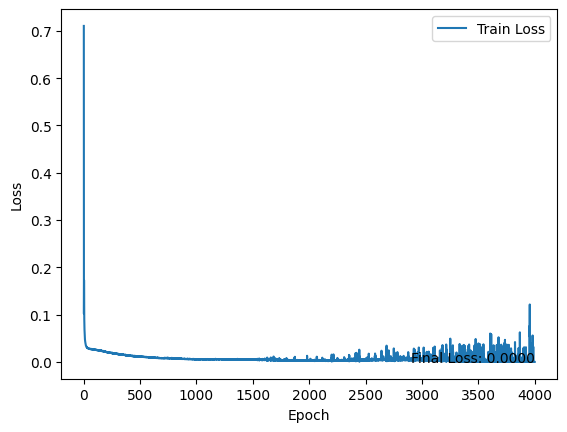

In [11]:
plt.plot(range(1, EPOCHS + 1), LOSS_LIST, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.text(EPOCHS, LOSS_LIST[-1], f'Final Loss: {LOSS_LIST[-1]:.4f}', ha='right', va='baseline')
plt.legend()

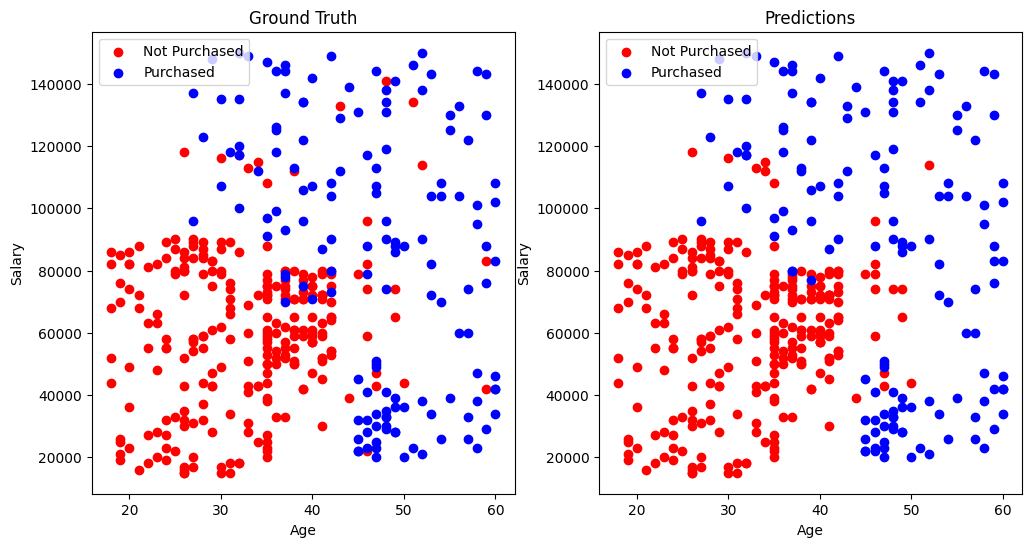

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

ax1.scatter(X.iloc[:, 0][Y == 0], X.iloc[:, 1][Y == 0], color='red', label='Not Purchased')
ax1.scatter(X.iloc[:, 0][Y == 1], X.iloc[:, 1][Y == 1], color='blue', label='Purchased')
ax1.set_title('Ground Truth')
ax1.set_xlabel('Age')
ax1.set_ylabel('Salary')
ax1.legend()

ax2.scatter(X.iloc[:, 0][results.flatten() == 0], X.iloc[:, 1][results.flatten() == 0], color='red', label='Not Purchased')
ax2.scatter(X.iloc[:, 0][results.flatten() == 1], X.iloc[:, 1][results.flatten() == 1], color='blue', label='Purchased')
ax2.set_title('Predictions')
ax2.set_xlabel('Age')
ax2.set_ylabel('Salary')
ax2.legend()

plt.show()